In [1]:
import torch
import numpy as np


import torchvision
from torchvision import models

import torch.nn as nn

from skimage import io

import random
import time
import os.path


import matplotlib.pyplot as plt
from IPython.display import clear_output


from sklearn.metrics import accuracy_score
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable


In [3]:
lr = 0.001             
milestones = [50,75,90] 
epochs = 100            

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
def iloader(path):
    image = np.asarray((io.imread(path))/32000,dtype='float32')
    return image.transpose(2,0,1)

In [6]:
def make_dataloaders():
    
    batch_size_val = 128
    
    data = torchvision.datasets.DatasetFolder(root=root,loader = iloader, transform=None, extensions = 'jpg')
    train_set, val_set = train_test_split(data, test_size = 0.2, stratify = data.targets)
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_val, shuffle=True, num_workers=3, drop_last = True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size_val, shuffle=True, num_workers=0, drop_last = True)

    return train_loader, val_loader

In [7]:
def get_random_pos(img, window_shape = [55,55] ):
    """ Extract of 2D random patch of shape window_shape in the image """
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = random.randint(0, W - w - 1)
    #x2 = x1 + w
    y1 = random.randint(0, H - h - 1)
    #y2 = y1 + h
    return x1, x1 + w, y1, y1 + h #x1, x2, y1, y2

def random_crop_area(img):
    x1,x2,y1,y2 = get_random_pos(img)
    Sen_Im = img[:, x1:x2,y1:y2]
    return resize(Sen_Im,img.shape,anti_aliasing=True)



def sigmoid(z):
    # np.clip limits the values in the array to be between -100 and a large positive number
    z = np.clip(z, -100, np.inf)
    #    z = np.clip(z, -100, 100)

    return 1 / (1 + np.exp(-z))




def cus_aug(data):
    data = torch.rot90(data,random.randint(-3,3), dims=random.choice([[3,2],[2,3]]))
    if random.random()>0.75:
        data = torch.flip(data, dims = random.choice([[2,],[3,],[2,3]]))
    pixmis = torch.empty_like(data).random_(data.shape[-1])
    pixmis = torch.where(pixmis>(data.shape[-1]/8),torch.ones_like(data),torch.zeros_like(data))
    return data* pixmis

In [8]:
def Load_model():
    #model_ft = models.resnet18()  # Using resnet18 during initial development
    model_ft = models.resnet50()  
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 10)
    
    inBands = 3

    model_ft.conv1 = nn.Conv2d(inBands, 64, kernel_size=7, stride=2, padding = 3, bias = False)

    print('Model Loaded')

    return model_ft.to(device)

In [9]:
def accuracy(gt_S,pred_S):       
    _, alp = torch.max(torch.from_numpy(pred_S), 1)
    #Can use F1 score isntead
    return accuracy_score(gt_S,np.asarray(alp)) x

In [10]:
def validation(model, test_,):
    model.eval()
    test_iter=0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_):
            data, target = cus_aug(Variable(data.to(device))), Variable(target.to(device)) x
            output = model(data)
            _, pred = torch.max(output, 1)
            pred = output.data.cpu().numpy()
            gt = target.data.cpu().numpy()
            if test_iter==0:
                all_pred=pred
                all_gt=gt
            else:
                all_pred=np.vstack((all_pred,pred))
                all_gt  =np.vstack((all_gt,gt))

            test_iter=test_iter+1
        acc=accuracy(all_gt.reshape(all_gt.shape[0] * all_gt.shape[1]),all_pred)
        model.train()
        return acc

In [11]:
def train(net, train_, val_, criterion, optimizer, epochs=None, scheduler=None, weights=None, save_epoch = 1):
    losses=[]; acc=[]; mean_losses=[]; val_acc=[]
    iter_ = t0 =0
    for e in range(1, epochs + 1):
        net.train()
        for batch_idx, (data, target) in enumerate(train_):
            data, target =  cus_aug(Variable(data.to(device))), Variable(target.to(device)), x
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            losses = np.append(losses,loss.item())
            mean_losses = np.append(mean_losses, np.mean(losses[max(0,iter_-100):iter_]))
            if iter_ % 40 == 0: #vary how often you want to update plots
                clear_output()
                print('Iteration Number',iter_,'{} seconds'.format(time.time() - t0))
                t0 = time.time()
                pred = output.data.cpu().numpy()
                pred=sigmoid(pred)
                gt = target.data.cpu().numpy()
                acc = np.append(acc,accuracy(gt,pred))
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}\tLearning Rate:{}'.format(
                    e, epochs, batch_idx, len(train_),
                    100. * batch_idx / len(train_), loss.item(), acc[-1],optimizer.param_groups[0]['lr']))
                plt.plot(mean_losses) and plt.show()
                val_acc = np.append(val_acc,validation(net, val_))
                print('validation accuracy : {}'.format(val_acc[-1]))
                plt.plot( range(len(acc)) ,acc,'b',label = 'training')
                plt.plot( range(len(val_acc)), val_acc,'r--',label = 'validation')
                plt.legend() and plt.show()
            iter_ += 1
            
            del(data, target, loss)
        if scheduler is not None:
           scheduler.step()
        if e % save_epoch == 0:
            
            torch.save(net.state_dict(), '.\Eurosat{}'.format(e))
    return net

In [12]:
#if EuroSat_Type == 'RGB':

data_folder = 'C:/dev/EuroSAT/'
root = os.path.join(data_folder, '2750/')

In [13]:
print(device)

cuda


In [14]:
if __name__ == '__main__':
    torch.manual_seed(0)
    np.random.seed(0)
    torch.cuda.manual_seed(0)
    random.seed(0)
    print("pytorch version", torch.__version__)
    criteria = torch.nn.CrossEntropyLoss()
    net = Load_model()
    train_loader, val_loader =make_dataloaders()
    net=net.to(device) # Move model to CPU
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)


pytorch version 2.1.2
Model Loaded


In [16]:
net.

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Iteration Number 16760 18.23000478744507 seconds
Train (epoch 100/100) [128/168 (76%)]	Loss: 0.030654	Accuracy: 0.9921875	Learning Rate:1e-05


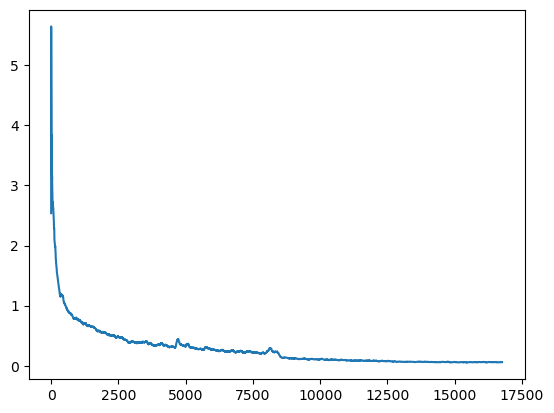

validation accuracy : 0.9505208333333334


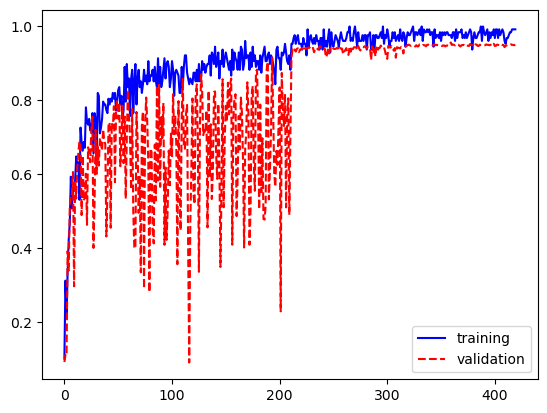

In [15]:
net = train(net, train_loader, val_loader, criteria, optimizer, epochs, scheduler)
